# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))
print(grad)

loss: 2.353873
sanity check: 2.302585
[[-1.43503292e+00  1.20787779e+00 -5.58492096e-01 ...  6.74271983e-02
  -2.55097663e+00 -4.44155812e+00]
 [-2.20476953e+00  1.94625070e+00 -1.23579014e+00 ... -4.98604327e-03
  -3.77350737e+00 -4.86179221e+00]
 [-3.53720097e+00  1.30223061e+00 -3.89293477e-01 ...  2.82015786e-02
  -5.46124065e+00 -5.83831598e+00]
 ...
 [ 2.00683645e-01  2.19594116e+00 -2.57734548e+00 ... -1.98175594e+00
   1.10063990e+00 -1.74310587e+00]
 [-1.13281803e+00  6.65593400e-01 -1.87059461e+00 ... -2.85961106e-01
  -6.00786440e-01 -2.13126074e+00]
 [ 1.57267604e-02 -1.13628147e-02  3.45491264e-03 ... -2.44988630e-02
  -1.61161260e-03  3.63865871e-03]]


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*

Since we choose randomly in 10 classes, such as roll the ten-eyes dices, expection value should be 0.1.

In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)
print('====')
# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 3.076154 analytic: 3.076154, relative error: 1.240212e-08
numerical: 1.719137 analytic: 1.719137, relative error: 3.398000e-08
numerical: 3.242125 analytic: 3.242125, relative error: 2.270413e-08
numerical: 0.248773 analytic: 0.248773, relative error: 7.983540e-08
numerical: -2.605070 analytic: -2.605070, relative error: 2.983836e-10
numerical: -0.328468 analytic: -0.328468, relative error: 6.296002e-08
numerical: 3.527279 analytic: 3.527279, relative error: 1.371111e-08
numerical: 0.377115 analytic: 0.377115, relative error: 6.228355e-08
numerical: -1.871091 analytic: -1.871091, relative error: 4.604846e-09
numerical: -0.495293 analytic: -0.495294, relative error: 1.527492e-07
====
numerical: -1.905658 analytic: -1.905658, relative error: 8.084792e-09
numerical: 2.603440 analytic: 2.603440, relative error: 2.896715e-08
numerical: 0.913604 analytic: 0.913604, relative error: 4.377485e-08
numerical: -1.543381 analytic: -1.543381, relative error: 7.656807e-09
numerical: 2.4552

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.353873e+00 computed in 0.081660s
vectorized loss: 2.353873e+00 computed in 0.002118s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 776.206010
iteration 100 / 1500: loss 284.887620
iteration 200 / 1500: loss 105.406081
iteration 300 / 1500: loss 39.904183
iteration 400 / 1500: loss 15.913320
iteration 500 / 1500: loss 7.141571
iteration 600 / 1500: loss 3.920972
iteration 700 / 1500: loss 2.767948
iteration 800 / 1500: loss 2.374868
iteration 900 / 1500: loss 2.172309
iteration 1000 / 1500: loss 2.115785
iteration 1100 / 1500: loss 2.135130
iteration 1200 / 1500: loss 2.096933
iteration 1300 / 1500: loss 2.053600
iteration 1400 / 1500: loss 2.010447
That took 3.166737s


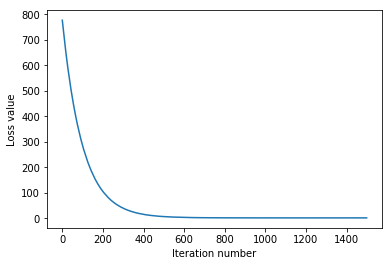

In [7]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [8]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.329816
validation accuracy: 0.349000


In [9]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 1e-6, 1e-5, 5e-5]
regularization_strengths = [5e4, 1e4, 1e5]
#learning_rates = [1e-7, 5e-7]
#regularization_strengths = [5e4, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates: 
    for reg in regularization_strengths:
        loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=5e4, num_iters=300, verbose=True)
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 300: loss 2.015709
iteration 100 / 300: loss 2.114036
iteration 200 / 300: loss 2.096802
training accuracy: 0.329408
validation accuracy: 0.344000
iteration 0 / 300: loss 2.101940
iteration 100 / 300: loss 2.070977
iteration 200 / 300: loss 1.986928
training accuracy: 0.329551
validation accuracy: 0.344000
iteration 0 / 300: loss 2.115467
iteration 100 / 300: loss 2.054394
iteration 200 / 300: loss 2.102566
training accuracy: 0.332000
validation accuracy: 0.352000
iteration 0 / 300: loss 2.127291
iteration 100 / 300: loss 2.052545
iteration 200 / 300: loss 2.118579
training accuracy: 0.330469
validation accuracy: 0.352000
iteration 0 / 300: loss 2.066844
iteration 100 / 300: loss 2.033741
iteration 200 / 300: loss 2.097456
training accuracy: 0.325469
validation accuracy: 0.344000
iteration 0 / 300: loss 2.103668
iteration 100 / 300: loss 2.063156
iteration 200 / 300: loss 2.140603
training accuracy: 0.331429
validation accuracy: 0.346000
iteration 0 / 300: loss 2.062418
i

In [10]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.342000


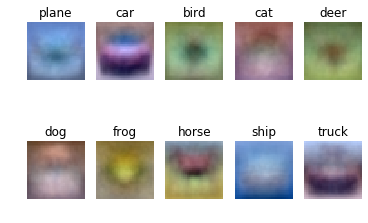

In [11]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])